# Round 3 data extraction

The round 3 candidates are not documented in this repository, but they *are* reported in a figure from the [Ruhlman conference presentation](https://docs.google.com/presentation/d/1w1cbO19pMLjWjZ81w3HZsD8YVXHn8s7xA6P3OIG01v8/edit#slide=id.gfb87c9a92b_0_783). Use WebPlotDigitizer to extract the values and convert them back to composition values.

## Setup

In [1]:
## Load packages
import grama as gr
import numpy as np
import pandas as pd
%matplotlib inline

## Package setup
DF = gr.Intention()

## Helper Functions

We used a consistent set of helper functions to construct ternary diagrams. Thus, the mapping from $x,y$ to composition can be done with the same helper functions we've been using.


In [2]:
## Barycentric converter
def tran_bary(df, a="I", b="Br", c="Cl", x="x", y="y"):
    r"""Convert to barycentric coordinates
    """
    df_tmp = df.copy()
    df_tmp[x] = 0.0 * df[a] + 1.0 * df[b] + 0.5 * df[c]
    df_tmp[y] = 0.0 * df[a] + 0.0 * df[b] + np.sqrt(1 - 0.5**2) * df[c]
    
    return df_tmp

## Inverse transform
def tran_thp(df, x="x", y="y", a="I", b="Br", c="Cl"):
    df_tmp = df.copy()
    xa = 0; ya = 0
    xb = 1; yb = 0
    xc = 0.5; yc = np.sqrt(1 - 0.5**2)
    d = (yb - yc) * (xa - xc) + (xc - xb) * (ya - yc)
    df_tmp[a] = ((yb - yc) * (df_tmp[x] - xc) + (xc - xb) * (df_tmp[y] - yc)) / d
    df_tmp[b] = ((yc - ya) * (df_tmp[x] - xc) + (xa - xc) * (df_tmp[y] - yc)) / d
    df_tmp[c] = 1 - df_tmp[a] - df_tmp[b]

    return df_tmp

# Pipe-enabled functions
tf_bary = gr.add_pipe(tran_bary)
tf_thp = gr.add_pipe(tran_thp)

## Metadata


In [3]:
# Triangle boundary
df_tri_bounds = (
    gr.df_make(
        Br=[1, 0, 0, 1],
        Cl=[0, 1, 0, 0],
        I =[0, 0, 1, 0],
    )
    >> tf_bary()
)

# Labels
df_tri_labels = (
    gr.df_make(
        x=[-0.1, +1.1, +0.5],
        y=[+0.0, +0.0, +np.sqrt(1 - 0.5**2) + 0.1],
        label=["I", "Br", "Cl"]
    )
)

# Guidelines
df_tri_guides = (
    gr.df_make(
        Br_0=[0.25, 0.5, 0.75, 0.25, 0.5, 0.75, 0.75, 0.5, 0.25],
        Br_1=[0.25, 0.5, 0.75, 0.00, 0.0, 0.00, 0.00, 0.0, 0.00],
        Cl_0=[0.75, 0.5, 0.25, 0.75, 0.5, 0.25, 0.00, 0.0, 0.00],
        Cl_1=[0.00, 0.0, 0.00, 0.75, 0.5, 0.25, 0.75, 0.5, 0.25],
        I_0 =[0.00, 0.0, 0.00, 0.00, 0.0, 0.00, 0.25, 0.5, 0.75],
        I_1 =[0.75, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25, 0.5, 0.75],
    )
    >> tf_bary(a="I_0", b="Br_0", c="Cl_0")
    >> tf_bary(a="I_1", b="Br_1", c="Cl_1", x="xend", y="yend")
)

# The Figure

The Round 3 candidates are reported in this figure.

![thp-final](./images/thp-final.png)

I can't find the original numerical values, but we can collect the data values in $x, y$ coordinates from this figure (using WebPlotDigitizer) and run a conversion back to composition. To do this, we'll need to calibrate the axes respecting the original helper functions.

*Note*: WebPlotDigitizer has a ternary diagram axis calibration, but it treats a single edge as an axis from 0% to 100% of a single element. Our ternary diagrams were defined with the corners corresponding to 100% of an element. These are incompatible definitions. Therefore, I'm extracting the data in $x, y$ coordinates and transforming them back to compositional fractions.


## Data Extraction

Based on our helper functions, the $x$-axis runs from $X_1 = 0$ to $X_2 = 1$. The y axis is more complex, with the largest value based on the base of an equilateral unit-side triangle:


In [4]:
y_max = np.sqrt(1 - 0.5**2)
y_max

0.8660254037844386

Thus, I calibrate the y axis with $Y_1 = 0$ and $Y_2 = 0.8660$ in WebPlotDigitizer:

![Calibration](./images/webplotdig-calibration-thp.png)

I extracted the values into three dataset:

- `extracted-round0.csv` - the Round 0 corner-points; to check the axis calibration
- `extracted-round3-true.csv` - the Round 3 Phase-stable == True cases
- `extracted-round3-false.csv` - the Round 3 Phase-stable == False cases


In [5]:
df_round0 = (
    pd.read_csv("./Data/extracted-round0.csv", names=["x", "y"])
    >> gr.tf_mutate(Round=0, single_phase=True)
)
df_round3 = (
    pd.read_csv("./Data/extracted-round3-true.csv", names=["x", "y"])
    >> gr.tf_mutate(Round=3, single_phase=True)
    >> gr.tf_bind_rows(
        pd.read_csv("./Data/extracted-round3-false.csv", names=["x", "y"])
        >> gr.tf_mutate(Round=3, single_phase=False)
    )
)
df_round3

,x,y,Round,single_phase
0,0.160671,0.085563,3,True
1,0.580336,0.571716,3,True
2,0.515588,0.719506,3,True
3,0.324940,0.146494,3,False
4,0.419664,0.276135,3,False
5,0.495204,0.425222,3,False


## Sanity-check the extracted values

Plot the extracted Round 0 and Round 3 points. See if they look sensible on the original ternary diagram.


/Users/zach/opt/anaconda3/envs/grama/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_segment : Removed 1 rows containing missing values.


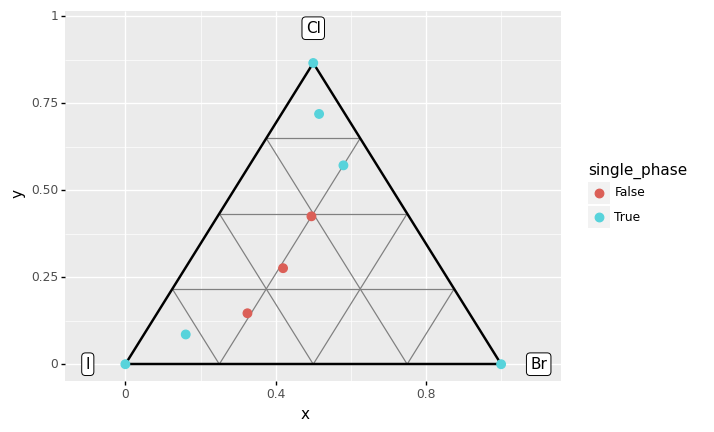

<ggplot: (8777261746207)>

In [6]:
(
    df_round0
    >> gr.tf_bind_rows(df_round3)
    
    >> gr.ggplot(gr.aes("x", "y"))
    # Guides
    + gr.geom_segment(
        data=df_tri_guides,
        mapping=gr.aes(xend="xend", yend="yend"),
        color="grey",
        size=0.5,
    )
    + gr.geom_label(
        data=df_tri_labels,
        mapping=gr.aes(label="label")
    )
    # Triangle border
    + gr.geom_segment(
        data=df_tri_bounds,
        mapping=gr.aes(xend="gr.lead(x)", yend="gr.lead(y)"),
        size=1.0,
    )
    # Data
    + gr.geom_point(gr.aes(color="single_phase"), size=3)
)

The points appear to be in the right locations. Additionally, we see that the "middle three" compositions are the ones that are not single phase; this matches the original figure above (sanity checking the `single_phase` values).

Convert the Round 0 data. These should be dead-on for single-halide compositions.


In [7]:
(
    df_round0
    >> tf_thp()
)

,x,y,Round,single_phase,I,Br,Cl
0,0.0,-2.220446e-16,0,True,1.000000e+00,1.281975e-16,-3.502421e-16
1,1.0,0.000000e+00,0,True,-1.922963e-16,1.000000e+00,0.000000e+00
2,0.5,8.660000e-01,0,True,1.466688e-05,1.466688e-05,9.999707e-01


The values are correct to within $O(10^{-5})$. We shouldn't need precision beyond two decimals, so this should be sufficient.


# Conversion


In [8]:
df_round3_converted = (
    df_round3
    >> tf_thp()
    >> gr.tf_select("Cl", "I", "Br", "single_phase", "Round")
)
df_round3_converted 

,Cl,I,Br,single_phase,Round
0,0.098799,0.789929,0.111272,True,3
1,0.660160,0.089584,0.250256,True,3
2,0.830814,0.069005,0.100181,True,3
3,0.169157,0.590482,0.240362,False,3
4,0.318853,0.420909,0.260238,False,3
5,0.491004,0.259294,0.249702,False,3


Save these to disk so we don't have this issue again....


In [9]:
df_round3_converted.to_csv("Data/measurements-round3.csv", index=False)
